In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
df = pd.read_csv('./new_df.csv')
df.head()

,subreddit,post
0,addiction,Deciding to go of tramadol Well after never ta...
1,addiction,My vyvanse addiction... It has gotten pretty b...
2,addiction,Quitting coke and nicotine I'm gonna start by ...
3,addiction,Is it OK to leave a drug addict you love? Man...
4,addiction,My brother has a problem I'm not against weed....


<Axes: title={'center': 'Number posts in each Subreddit'}, xlabel='subreddit'>

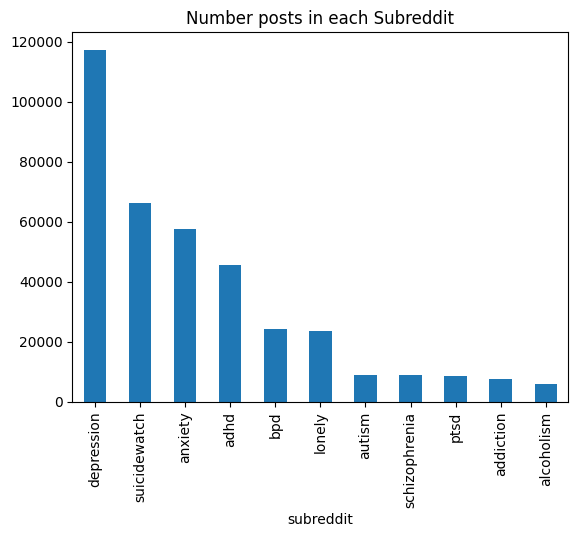

In [3]:
df['subreddit'].value_counts().sort_values(ascending=False).plot(kind='bar', 
                                                                title='Number posts in each Subreddit')

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
# from bs4 import BeautifulSoup
import plotly.graph_objs as go
import plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [5]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['post'] = df['post'].apply(clean_text)
df['post'] = df['post'].str.replace('\d+', '')

In [6]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 323310 unique tokens.


In [7]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (374499, 250)


In [8]:
Y = pd.get_dummies(df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (374499, 11)


In [9]:
# Oversample this data for better results
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X, Y = ros.fit_resample(X, Y)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1032512, 250) (1032512, 11)
(258129, 250) (258129, 11)


In [11]:
# print tensorflow version
import tensorflow as tf
print(tf.__version__)

2.15.0


In [12]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'RNN_scratch_aayush.ipynb'


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTMCell, RNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback

wandb.init(project='Reddit_mental_RNN')

# Your data: X_train, X_val, X_test, y_train_encoded, y_val_encoded, y_test_encoded

# Manual specification of parameters for the first run
params = {
    'units': 200, 'batch': 128 
}


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_acc,▁
test_loss,▁
val_accuracy,▁▅▇██
val_loss,█▃▂▁▁
accuracy,0.9465
best_epoch,4
best_val_loss,0.21594
epoch,4


In [20]:


# Assuming you have MAX_NB_WORDS, EMBEDDING_DIM, X, Y_train, Y_test defined elsewhere

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(RNN(LSTMCell(params['units']), return_sequences=False))  # Using LSTMCell here
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

epochs = 5
batch_size = params['batch']

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), WandbCallback()])

accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.7f}\n  Accuracy: {:0.7f}'.format(accr[0], accr[1]))

wandb.log({'test_loss': accr[0], 'test_acc': accr[1]})
wandb.log({'train_loss': history.history['loss'], 'val_loss': history.history['val_loss']})
wandb.log({'train_acc': history.history['accuracy'], 'val_acc': history.history['val_accuracy']})


# plt.title('Accuracy')
# plt.plot(history.history['accuracy'], label='train')
# plt.plot(history.history['val_accuracy'], label='test')
# plt.legend()
# plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 250, 100)          0         
 alDropout1D)                                                    
                                                                 
 rnn_2 (RNN)                 (None, 200)               240800    
                                                                 
 dense_2 (Dense)             (None, 11)                2211      
                                                                 
Total params: 5243011 (20.00 MB)
Trainable params: 5243011 (20.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
7260/7260 [==============================] - ETA: 0s - loss: 0.8205 - 

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best)... Done. 0.2s


7260/7260 [==============================] - 3207s 442ms/step - loss: 0.8205 - accuracy: 0.7272 - val_loss: 0.4423 - val_accuracy: 0.8565
Epoch 2/5
7260/7260 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.8799

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best)... Done. 0.2s


7260/7260 [==============================] - 3276s 451ms/step - loss: 0.3639 - accuracy: 0.8799 - val_loss: 0.3223 - val_accuracy: 0.8923
Epoch 3/5
7260/7260 [==============================] - ETA: 0s - loss: 0.2575 - accuracy: 0.9125

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best)... Done. 0.3s


7260/7260 [==============================] - 3153s 434ms/step - loss: 0.2575 - accuracy: 0.9125 - val_loss: 0.2729 - val_accuracy: 0.9085
Epoch 4/5
7260/7260 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.9317

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best)... Done. 0.2s


7260/7260 [==============================] - 3262s 449ms/step - loss: 0.1995 - accuracy: 0.9317 - val_loss: 0.2481 - val_accuracy: 0.9180
Epoch 5/5
7260/7260 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.9447

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231117_093353-roae6oai/files/model-best)... Done. 0.2s


8067/8067 [==============================] - 446s 55ms/step - loss: 0.2406 - accuracy: 0.9237
Test set
  Loss: 0.2406454
  Accuracy: 0.9236932


In [ ]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
# print(cm)


<Figure size 1000x1000 with 0 Axes>

<Axes: >

Text(95.72222222222221, 0.5, 'Actual label')

Text(0.5, 155.72222222222217, 'Predicted label')

Text(0.5, 1.0, 'Confusion matrix')

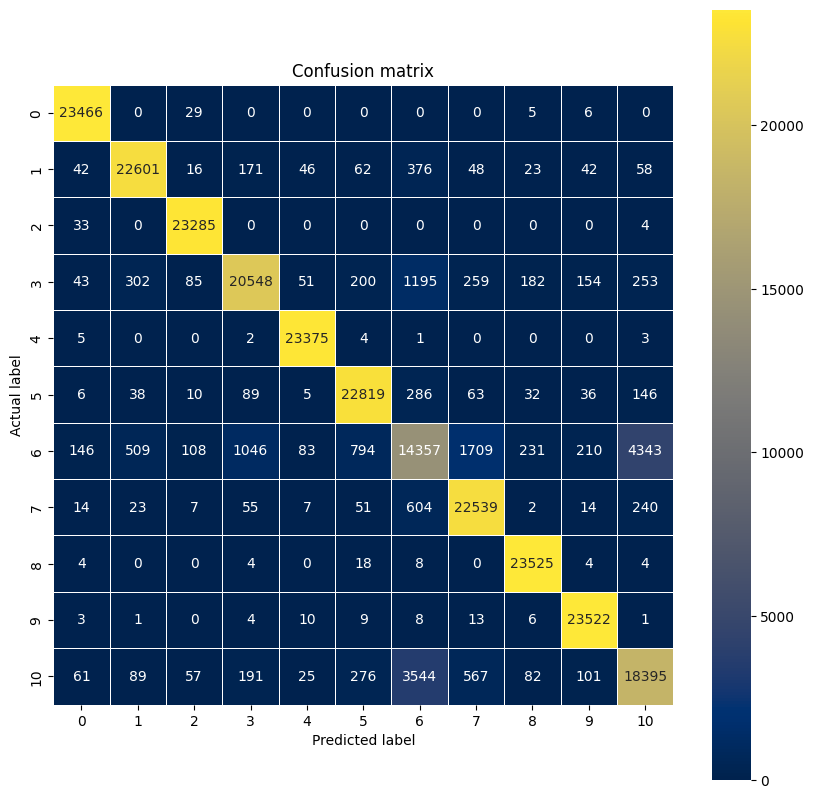

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'cividis')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()

In [18]:
del model